# Color Correction

<b>Histogram Matching</b>: Using histogram matching, we can take the color distribution of one image and match it to another.

A practical, real-world application of color matching is to perform basic color correction through color constancy. The goal of color constancy is to perceive the colors of objects correctly regardless of differences in light sources, illumination, etc. (which, as you can imagine, is easier said than done).

Photographers and computer vision practitioners can help obtain color constancy by using color correction cards, like this one:

<img src="figs/color_correction_pantone_card.png">

Using a color correction/color constancy card, we can:

- Detect the color correction card in an input image

- Compute the histogram of the card, which contains gradated colors of varying colors, hues, shades, blacks, whites, and grays

- Apply histogram matching from the color card to another image, thereby attempting to achieve color constancy

## ArUco marker detection

we may need install opencv-contrib-python to use "cv2.aruco" marker detector

Please note since opencv 4.7, the aruco dector interface has been changed. 

```bash
pip install opencv-contrib-python
```

In [4]:
from imutils.perspective import four_point_transform
from skimage import exposure
import numpy as np
import imutils
import cv2
from PIL import Image

import matplotlib.pyplot as plt

### Card detection and Perspective transform

In [2]:
def find_color_card(image):
    # load the ArUCo dictionary, grab the ArUCo parameters, and
    # detect the markers in the input image
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image,
                                                       arucoDict, parameters=arucoParams)

    # For OpenCV 4.7.0 and above, we need use this new API interfaces
    # arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
    # arucoParams = cv2.aruco.DetectorParameters()
    # detector = cv2.aruco.ArucoDetector(arucoDict, arucoParams)
    # (corners, ids, rejected) = detector.detectMarkers(image)

    # try to extract the coordinates of the color correction card
    try:
        # otherwise, we've found the four ArUco markers, so we can
        # continue by flattening the ArUco IDs list
        ids = ids.flatten()

        # extract the top-left marker
        i = np.squeeze(np.where(ids == 923))
        topLeft = np.squeeze(corners[i])[0]

        # extract the top-right marker
        i = np.squeeze(np.where(ids == 1001))
        topRight = np.squeeze(corners[i])[1]

        # extract the bottom-right marker
        i = np.squeeze(np.where(ids == 241))
        bottomRight = np.squeeze(corners[i])[2]

        # extract the bottom-left marker
        i = np.squeeze(np.where(ids == 1007))
        bottomLeft = np.squeeze(corners[i])[3]

    # we could not find color correction card, so gracefully return
    except:
        return None

    # build our list of reference points and apply a perspective
    # transform to obtain a top-down, bird’s-eye view of the color
    # matching card
    cardCoords = np.array([topLeft, topRight,
                           bottomRight, bottomLeft])
    card = four_point_transform(image, cardCoords)
    # return the color matching card to the calling function
    return card

### Reference card detection

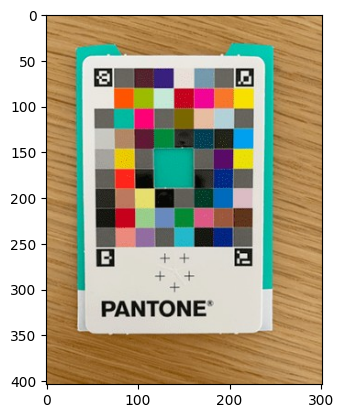

In [6]:
ref = cv2.imread("figs/ref.jpg")
ref_rgb = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
plt.imshow(ref_rgb)

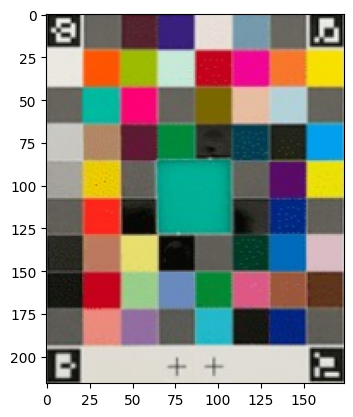

In [8]:
refCard = find_color_card(ref)
refCard_rgb = cv2.cvtColor(refCard, cv2.COLOR_BGR2RGB)
plt.imshow(refCard_rgb)

### Card detection from input image 

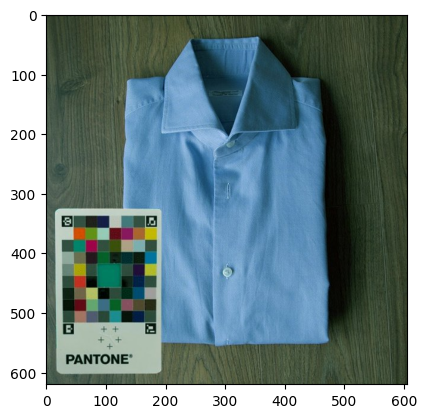

In [10]:
img = cv2.imread("figs/test.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

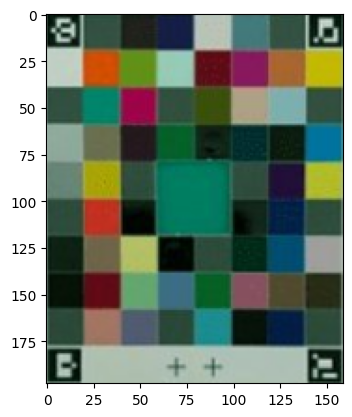

In [11]:
imgCard = find_color_card(img)
imgCard_rgb = cv2.cvtColor(imgCard, cv2.COLOR_BGR2RGB)
plt.imshow(imgCard_rgb)

### Histogram Matching

In [12]:
def _match_cumulative_cdf_mod(source, template, full):
    """
    Return modified full image array so that the cumulative density function of
    source array matches the cumulative density function of the template.
    """
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / template.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)

    # Here we compute values which the channel RGB value of full image will be modified to.
    interpb = []
    for i in range(0, 256):
        interpb.append(-1)

    # first compute which values in src image transform to and mark those values.

    for i in range(0, len(interp_a_values)):
        frm = src_values[i]
        to = interp_a_values[i]
        interpb[frm] = to

    # some of the pixel values might not be there in interp_a_values, interpolate those values using their
    # previous and next neighbours
    prev_value = -1
    prev_index = -1
    for i in range(0, 256):
        if interpb[i] == -1:
            next_index = -1
            next_value = -1
            for j in range(i + 1, 256):
                if interpb[j] >= 0:
                    next_value = interpb[j]
                    next_index = j
            if prev_index < 0:
                interpb[i] = (i + 1) * next_value / (next_index + 1)
            elif next_index < 0:
                interpb[i] = prev_value + ((255 - prev_value) * (i - prev_index) / (255 - prev_index))
            else:
                interpb[i] = prev_value + (i - prev_index) * (next_value - prev_value) / (next_index - prev_index)
        else:
            prev_value = interpb[i]
            prev_index = i

    # finally transform pixel values in full image using interpb interpolation values.
    wid = full.shape[1]
    hei = full.shape[0]
    ret2 = np.zeros((hei, wid))
    for i in range(0, hei):
        for j in range(0, wid):
            ret2[i][j] = interpb[full[i][j]]
    return ret2


def match_histograms_mod(inputCard, referenceCard, fullImage):
    """
        Return modified full image, by using histogram equalizatin on input and
         reference cards and applying that transformation on fullImage.
    """
    if inputCard.ndim != referenceCard.ndim:
        raise ValueError('Image and reference must have the same number '
                         'of channels.')
    matched = np.empty(fullImage.shape, dtype=fullImage.dtype)
    for channel in range(inputCard.shape[-1]):
        matched_channel = _match_cumulative_cdf_mod(inputCard[..., channel], referenceCard[..., channel],
                                                    fullImage[..., channel])
        matched[..., channel] = matched_channel
    return matched

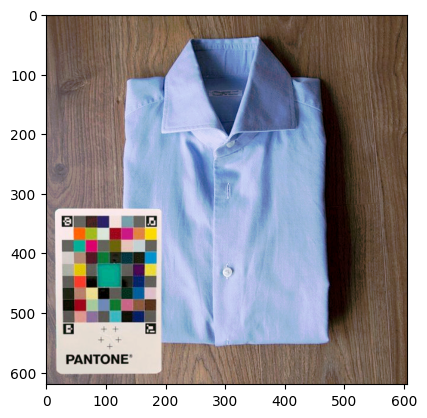

In [14]:
img_result = match_histograms_mod(imgCard, refCard, img)
img_result_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
plt.imshow(img_result_rgb)

In [15]:
cv2.imwrite("figs/output.jpg", img_result)

True